In [45]:
!pip install easyocr
!easyocr-download gemini

zsh:1: command not found: easyocr-download


In [3]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


In [4]:
from PIL import Image
import numpy as np
from model.deformer import deform_card
from model.prediction import card_prediction_processing
import matplotlib.pyplot as plt

# For OCR
import easyocr
import cv2

reader = easyocr.Reader(['en'], gpu=False, verbose=False)

def extract_card_number_debug(img_path, set_id, show_crop=True):
    # 1. Load and deskew image
    pil_img = Image.open(img_path).convert("RGB")
    aligned_img = deform_card(pil_img)

    # 2. Crop both bottom corners
    graybottomleft, graybottomright = card_prediction_processing(aligned_img)

    # Try increasing contrast or thresholding before OCR
    def preprocess_for_ocr(img):
        # Assume img is (H, W) uint8, 0–255
        blur = cv2.GaussianBlur(img, (3,3), 0)
        _, threshed = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return threshed


    # 3. Choose patch to OCR (adjust as needed for your sets!)
    # Here, let's try both and show both for debugging
    patch_left = (graybottomleft[0, :, :, 0] * 255).astype(np.uint8)
    patch_right = (graybottomright[0, :, :, 0] * 255).astype(np.uint8)

    if show_crop:
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        ax[0].imshow(patch_left, cmap='gray')
        ax[0].set_title("Bottom Left Crop")
        ax[0].axis('off')
        ax[1].imshow(patch_right, cmap='gray')
        ax[1].set_title("Bottom Right Crop")
        ax[1].axis('off')
        plt.show()

    pre_left = preprocess_for_ocr(patch_left)
    pre_right = preprocess_for_ocr(patch_right)
    plt.imshow(pre_left, cmap='gray')
    plt.title("Left Crop Preprocessed")
    plt.show()

    plt.imshow(pre_right, cmap='gray')
    plt.title("Right Crop Preprocessed")
    plt.show()


    # 4. OCR both crops
    print("Left Crop OCR:")
    ocr_left = reader.readtext(cv2.cvtColor(patch_left, cv2.COLOR_GRAY2BGR), allowlist="0123456789/", batch_size=1)
    print(ocr_left)
    print("Right Crop OCR:")
    ocr_right = reader.readtext(cv2.cvtColor(patch_right, cv2.COLOR_GRAY2BGR), allowlist="0123456789/", batch_size=1)
    print(ocr_right)

    return ocr_left, ocr_right


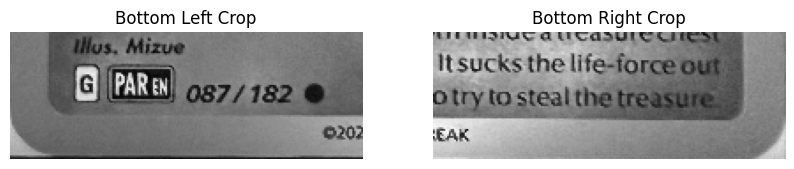

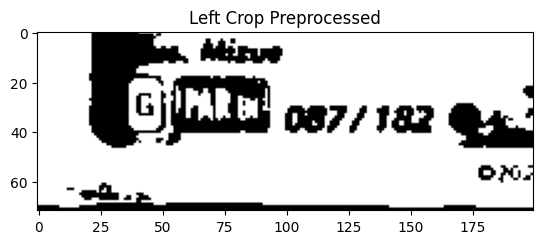

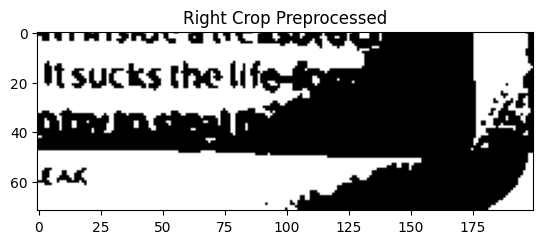

Left Crop OCR:


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[([[33, 1], [61, 1], [61, 15], [33, 15]], '05', 0.34986002796632526), ([[65, 1], [101, 1], [101, 15], [65, 15]], '608', 0.15416477030273784), ([[55, 19], [93, 19], [93, 39], [55, 39]], '/3/07', 0.16541244391197427), ([[99, 27], [163, 27], [163, 43], [99, 43]], '087/182', 0.9999780572235102), ([[177, 51], [199, 51], [199, 63], [177, 63]], '0202', 0.24269843101501465)]
Right Crop OCR:
[([[1, 11], [165, 11], [165, 27], [1, 27]], '15/5/204', 0.2065761317656432), ([[0, 31], [161, 31], [161, 47], [0, 47]], '0053/1', 0.5100197079746195), ([[0, 53], [23, 53], [23, 65], [0, 65]], '40', 0.1301058790541434)]


In [7]:
# Example usage (NUMBER APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/IMG_9398.jpg", set_id="sv4")

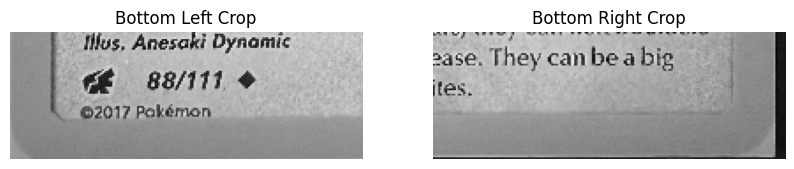

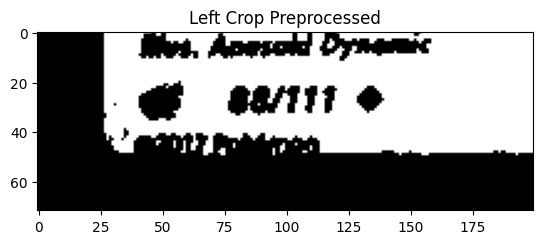

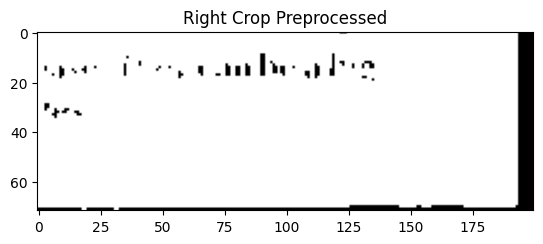

Left Crop OCR:
[([[39, 0], [65, 0], [65, 13], [39, 13]], '835', 0.27040722022802083), ([[69, 0], [163, 0], [163, 13], [69, 13]], '42/', 0.13961391034682072), ([[77, 21], [125, 21], [125, 37], [77, 37]], '88/111', 0.7279959040177368), ([[39, 39], [115, 39], [115, 53], [39, 53]], '020178/15', 0.16211637529407819)]
Right Crop OCR:
[([[0, 7], [107, 7], [107, 23], [0, 23]], '352936', 0.15741010282032575), ([[117, 7], [139, 7], [139, 25], [117, 25]], '1/', 0.3440801633880231), ([[0, 25], [21, 25], [21, 39], [0, 39]], '/53', 0.23415768041067936)]


In [8]:
# Example usage (NUMBER APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/IMG_9399.jpg", set_id="sm4")

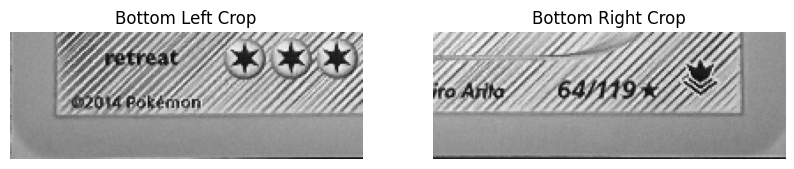

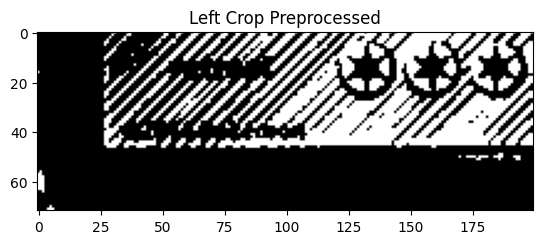

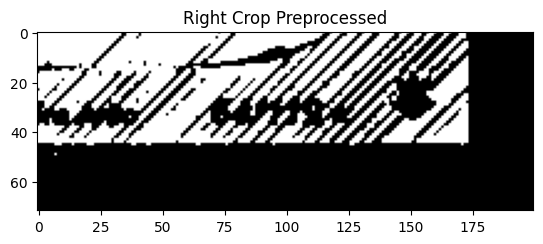

Left Crop OCR:
[([[55, 9], [99, 9], [99, 23], [55, 23]], '13', 0.423581397193405), ([[36, 36], [62, 36], [62, 44], [36, 44]], '052014', 0.02192660427445448), ([[66, 36], [108, 36], [108, 44], [66, 44]], '', 0.0)]
Right Crop OCR:
[([[17, 29], [43, 29], [43, 41], [17, 41]], '4', 0.9848153891354663), ([[69, 25], [125, 25], [125, 41], [69, 41]], '64/1494', 0.22080997896851412)]


In [9]:
# Example usage (ONLY NUMBER INFRONT OF / APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/IMG_9400.jpg", set_id="xy4")

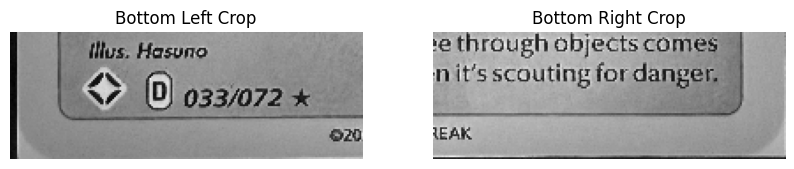

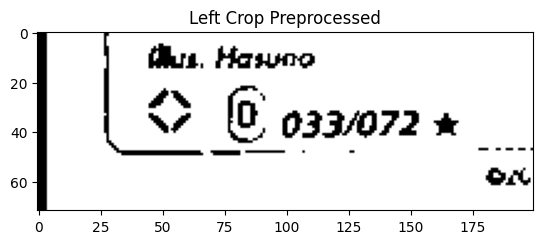

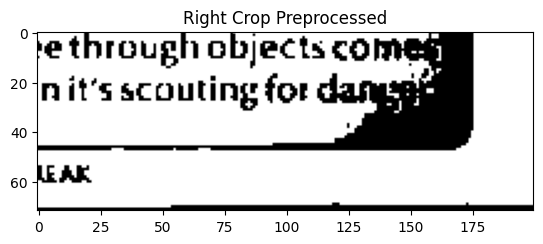

Left Crop OCR:
[([[43, 5], [115, 5], [115, 19], [43, 19]], '1355', 0.31701982021331787), ([[97, 29], [157, 29], [157, 45], [97, 45]], '033/072', 0.9998389625373638)]
Right Crop OCR:
[([[12, 0], [165, 0], [165, 17], [12, 17]], '//5', 0.35251181887372357), ([[0, 17], [33, 17], [33, 31], [0, 31]], '05', 0.7642877893874697), ([[29, 12], [164, 12], [164, 37], [29, 37]], '54/04', 0.09278877797402851), ([[0, 51], [25, 51], [25, 65], [0, 65]], '40', 0.4369368879416978)]


In [10]:
# Example usage (NUMBER APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/IMG_9401.jpg", set_id="swsh45")

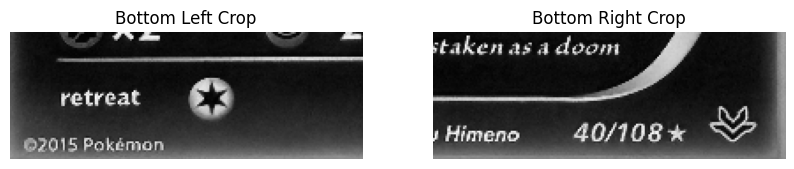

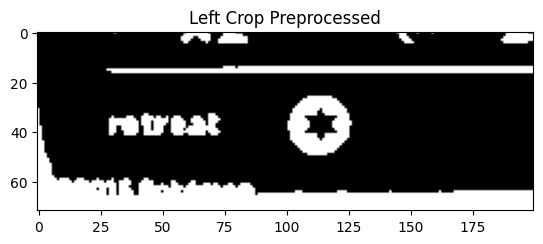

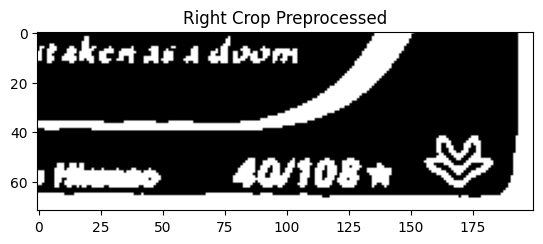

Left Crop OCR:
[([[31, 0], [57, 0], [57, 11], [31, 11]], '', 0.0), ([[27, 31], [77, 31], [77, 45], [27, 45]], '/3', 0.08019827273711722), ([[7, 59], [89, 59], [89, 71], [7, 71]], '020158/', 0.2802503831275258)]
Right Crop OCR:
[([[0, 1], [59, 1], [59, 17], [0, 17]], '404', 0.2772704385306829), ([[67, 1], [109, 1], [109, 17], [67, 17]], '40', 0.20003544167913787), ([[5, 51], [51, 51], [51, 65], [5, 65]], '9', 0.0766242987626562), ([[79, 49], [147, 49], [147, 65], [79, 65]], '40/1084', 0.6870270307947761)]


In [11]:
# Example usage (ONLY NUMBER INFRONT OF / APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/IMG_9402.jpg", set_id="xy6")

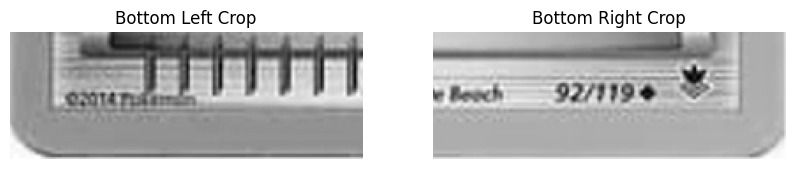

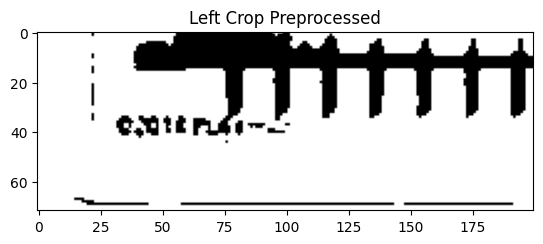

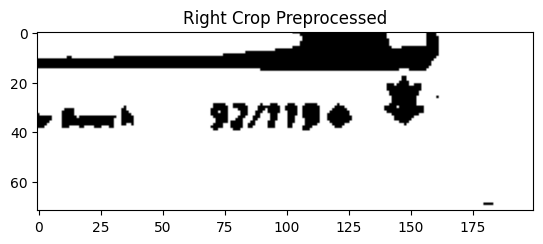

Left Crop OCR:
[]
Right Crop OCR:
[([[0, 27], [43, 27], [43, 43], [0, 43]], '7', 0.06323801503791415), ([[67, 27], [127, 27], [127, 43], [67, 43]], '92/8190', 0.06278388634207173)]


In [12]:
# Example usage (ONLY NUMBER INFRONT OF / APPEARS CORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/1415199121-32734000__32688.jpg", set_id="xy6")

No contour was found. Exiting.
2025-05-30 17:15:17,020 [WARNING] model.deformer: No contour was found. Exiting.


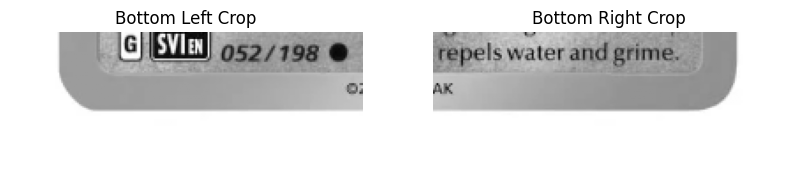

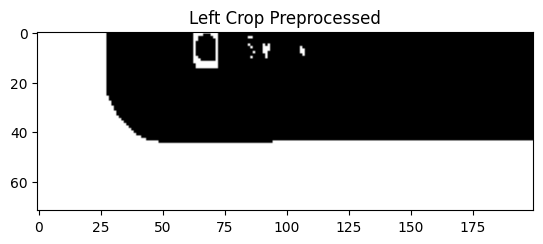

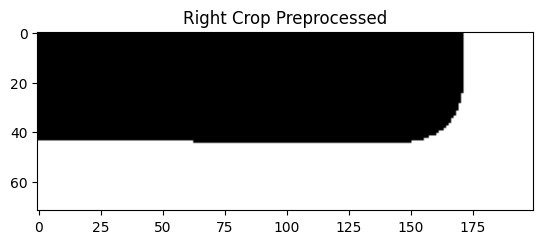

Left Crop OCR:
[([[79, 0], [115, 0], [115, 17], [79, 17]], '9', 0.17000580642524543), ([[119, 5], [179, 5], [179, 19], [119, 19]], '052/198', 0.8782710830136411)]
Right Crop OCR:
[([[0, 4], [139, 4], [139, 23], [0, 23]], '1/51//14/', 0.09881289326167658)]


In [13]:
# Example usage (NUMBER APPEARS CORRECT, but no contour found):
ocr_left, ocr_right = extract_card_number_debug("../images_example/pokemon_tcg_scarlet_violet_052_quaxly.jpg.webp", set_id="xy6")

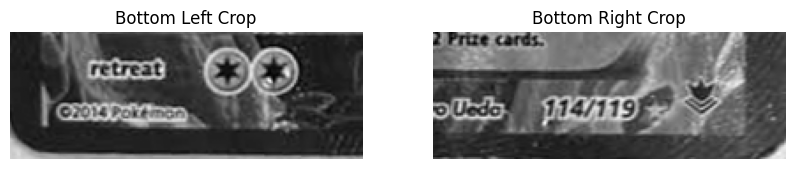

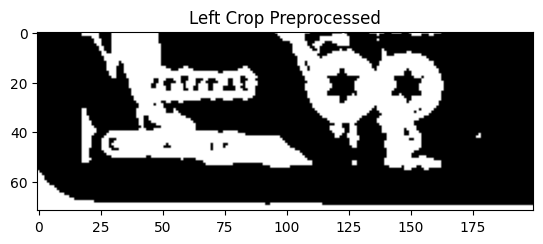

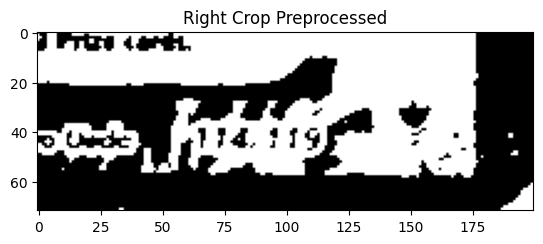

Left Crop OCR:
[([[25, 39], [83, 39], [83, 53], [25, 53]], '02', 0.16323528850139857)]
Right Crop OCR:
[([[0, 32], [43, 32], [43, 53], [0, 53]], '50', 0.5601976063530629), ([[56, 32], [118, 32], [118, 56], [56, 56]], '113119', 0.2379543179355652)]


In [14]:
# Example usage (CARD INCORRECT):
ocr_left, ocr_right = extract_card_number_debug("../images_example/278478069_5272519142808356_2360382924951171933_n.jpg", set_id="xy6")

In [15]:
import matplotlib.pyplot as plt
import cv2
import easyocr
from PIL import Image
from model.deformer import deform_card
from model.prediction import card_prediction_processing

reader = easyocr.Reader(['en'], gpu=False)

def preprocess_for_ocr(img):
    # Example: Gaussian blur + Otsu threshold
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    _, threshed = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return threshed

def debug_ocr_pipeline(img_path):
    pil_img = Image.open(img_path).convert("RGB")
    aligned = deform_card(pil_img)
    left, right = card_prediction_processing(aligned)
    # Assume output shape (1, 72, 200, 1), convert to uint8
    left_patch = (left[0, :, :, 0] * 255).astype('uint8')
    right_patch = (right[0, :, :, 0] * 255).astype('uint8')
    pre_left = preprocess_for_ocr(left_patch)
    pre_right = preprocess_for_ocr(right_patch)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(pre_left, cmap='gray')
    plt.title('Left')
    plt.subplot(1,2,2)
    plt.imshow(pre_right, cmap='gray')
    plt.title('Right')
    plt.show()
    print('Left OCR:', reader.readtext(pre_left, allowlist="0123456789/"))
    print('Right OCR:', reader.readtext(pre_right, allowlist="0123456789/"))


2025-05-30 17:15:39,686 [WARNING] easyocr.easyocr: Using CPU. Note: This module is much faster with a GPU.


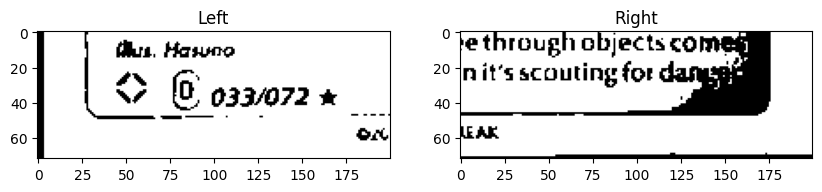

Left OCR: [([[71, 5], [115, 5], [115, 19], [71, 19]], '8', 0.04772928076702265), ([[95, 27], [173, 27], [173, 47], [95, 47]], '033/0721', 0.8844408822282446), ([[45.390289239150306, 3.2073760108954], [67.97513285579146, 7.778378896411032], [65.6097107608497, 17.7926239891046], [44.02486714420854, 13.221621103588967]], '0', 0.2127036796096604)]
Right OCR: [([[10, 0], [159, 0], [159, 17], [10, 17]], '/0//6', 0.1200512408716893), ([[0, 17], [33, 17], [33, 31], [0, 31]], '5', 0.4123873002445322), ([[29, 12], [138, 12], [138, 36], [29, 36]], '5885', 0.17450594902038574), ([[0, 51], [25, 51], [25, 65], [0, 65]], '14', 0.10569447984502675)]


In [16]:
debug_ocr_pipeline('../images_example/IMG_9401.jpg')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from model.deformer import deform_card
from model.prediction import card_prediction_processing
from model.text_detection import get_pokeid

def debug_card_number_ocr(img_path, set_id):
    # 1. Show original image
    pil_img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(5,5))
    plt.imshow(pil_img)
    plt.title("Original Card Image")
    plt.axis('off')
    plt.show()

    # 2. Align card
    aligned_img = deform_card(pil_img)
    plt.figure(figsize=(5,5))
    plt.imshow(aligned_img)
    plt.title("Aligned Card Image")
    plt.axis('off')
    plt.show()

    # 3. Crop bottom corners for OCR
    graybottomleft, graybottomright = card_prediction_processing(aligned_img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(graybottomleft[0,:,:,0], cmap='gray')
    plt.title("Bottom Left Crop")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(graybottomright[0,:,:,0], cmap='gray')
    plt.title("Bottom Right Crop")
    plt.axis('off')
    plt.show()

    # 4. Get card number using OCR (on full aligned image and set_id)
    poke_id = get_pokeid(aligned_img, set_id)
    print(f"Predicted card number for set '{set_id}': {poke_id}")
    return poke_id


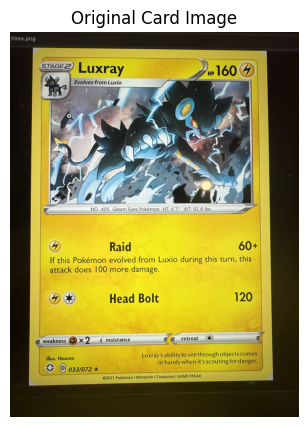

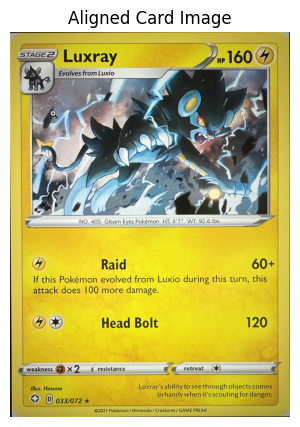

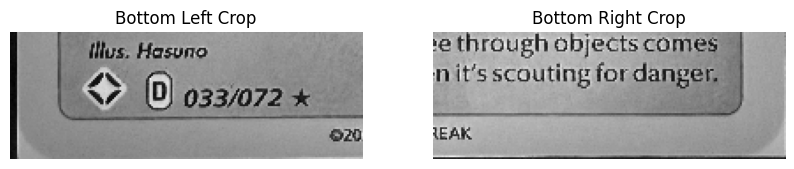

Predicted card number for set 'sv4': 33


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [37]:
# Usage example:
poke_id = debug_card_number_ocr("../images_example/IMG_9401.jpg", set_id="sv4")

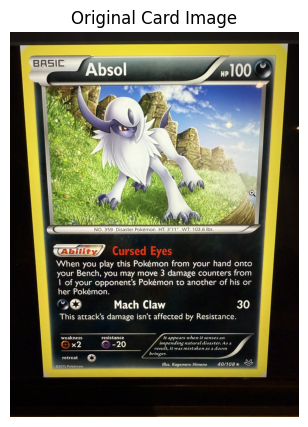

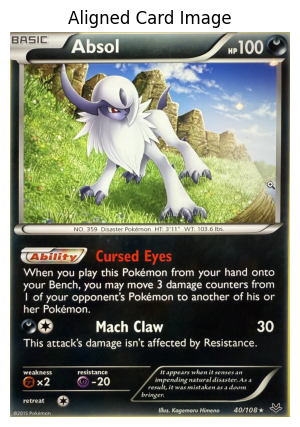

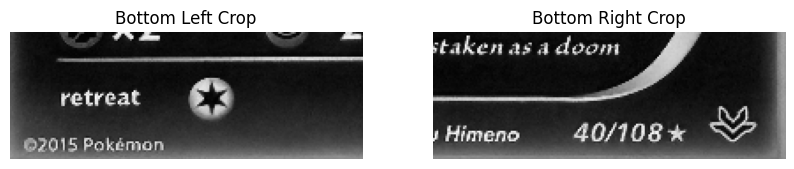

Predicted card number for set 'sv4': 1


In [40]:
poke_id = debug_card_number_ocr("../images_example/IMG_9402.jpg", set_id="sv4")

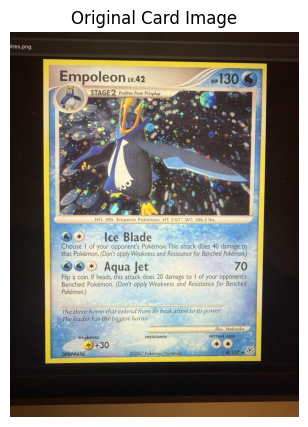

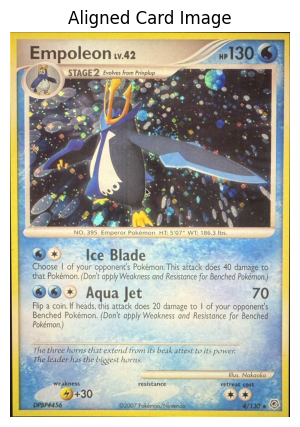

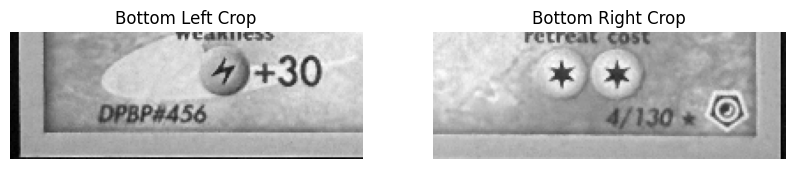

Predicted card number for set 'sv4': 578


In [44]:
poke_id = debug_card_number_ocr("../images_example/IMG_9417.jpg", set_id="sv4")